In [29]:
# Install numpy version <2 if needed
# !pip install "numpy<2.0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
import warnings

warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

# === DATASET VISUALIZATION AND LOADING ===

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)
120


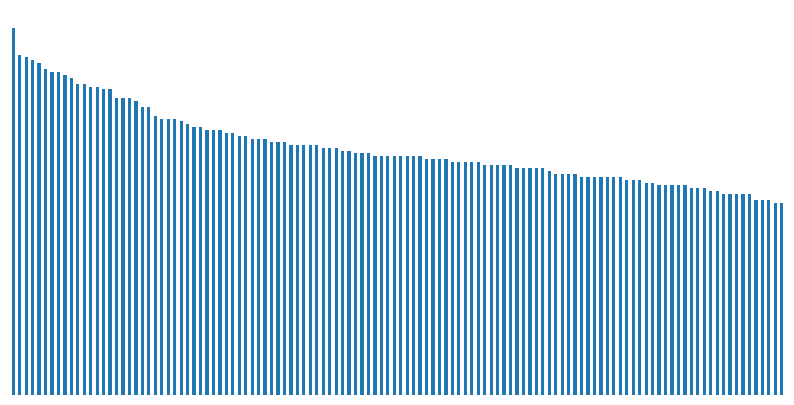

                                 id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                     filepath  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  train/001cdf01b096e06d78e9e5112d419397.jpg  
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg  


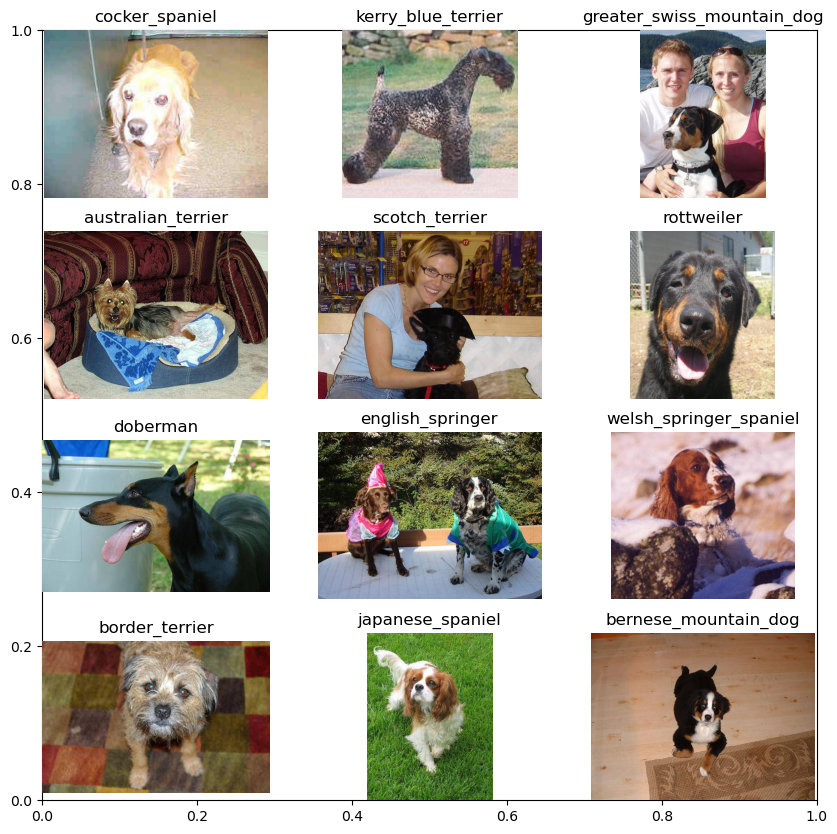

In [30]:
df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)
print(df['breed'].nunique())
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

df['filepath'] = 'train/' + df['id'] + '.jpg'
print(df.head())

plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()


# === LABEL ENCODING AND SPLITTING ===

In [31]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
features = df['filepath']
target = df['breed']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)

# === KERAS GENERATOR EXAMPLE PREVIEW ===

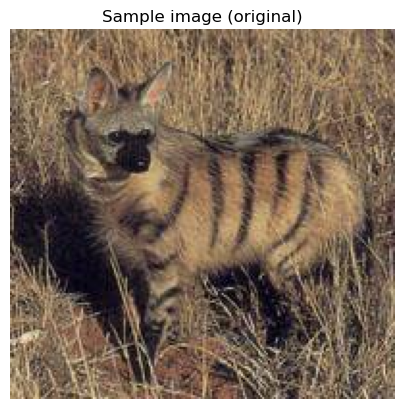

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
)

img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample image (original)")
plt.axis("off")
plt.show()

# === AUGMENTATION DEMO FUNCTIONS ===

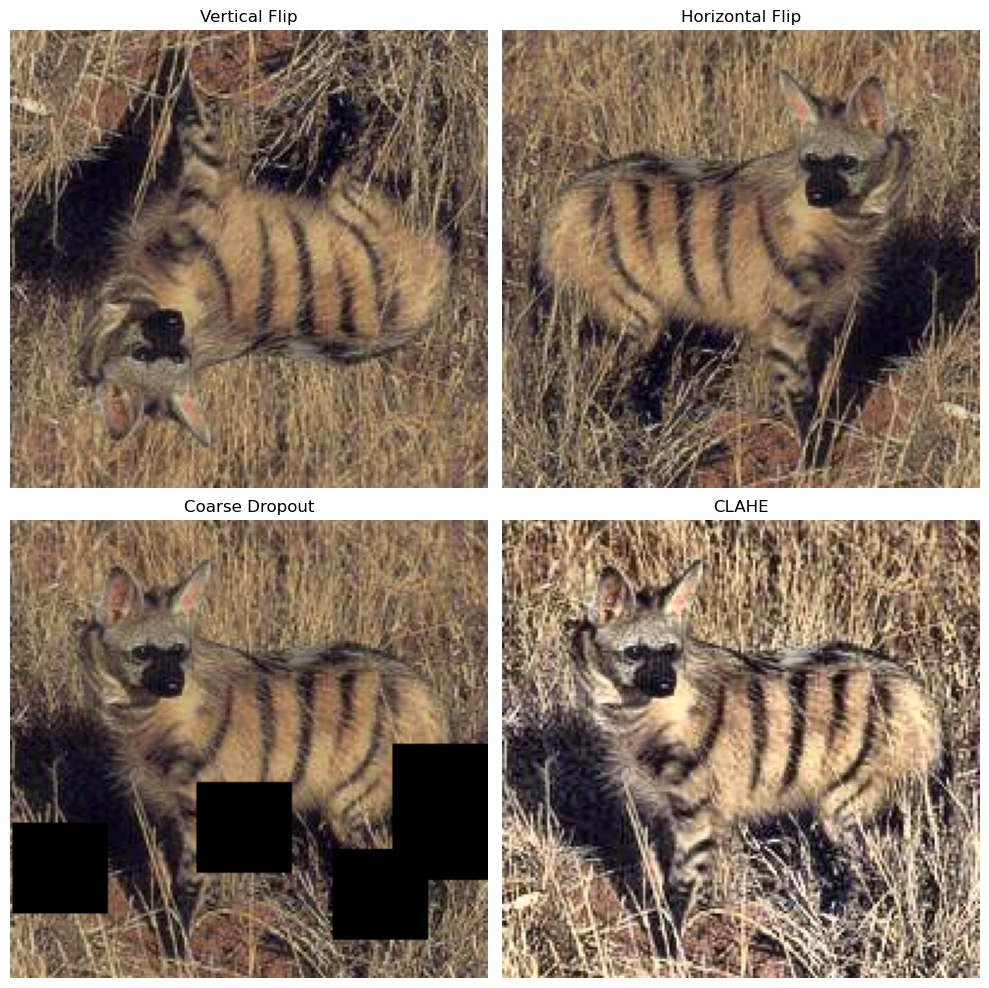

In [33]:
def vertical_flip(img):
    return tf.image.flip_up_down(img).numpy()

def horizontal_flip(img):
    return tf.image.flip_left_right(img).numpy()

def coarse_dropout(img, size_ratio=0.2, n_holes=5):
    h, w, c = img.shape
    mask = np.ones((h, w), np.float32)
    for _ in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)
        height = int(h * size_ratio)
        width = int(w * size_ratio)
        y1 = np.clip(y, 0, h - height)
        x1 = np.clip(x, 0, w - width)
        mask[y1:y1+height, x1:x1+width] = 0
    img = img * mask[..., None]
    return img.astype(np.uint8)

def clahe(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    _clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = _clahe.apply(img_yuv[:,:,0])
    clahe_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return clahe_img

augments = [
    ("Vertical Flip", vertical_flip),
    ("Horizontal Flip", horizontal_flip),
    ("Coarse Dropout", coarse_dropout),
    ("CLAHE", clahe)
]

plt.figure(figsize=(10, 10))
for i, (name, aug) in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(img)
    plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

# === MAIN PIPELINE ===
# IMAGE DECODING FN FOR DATASET PIPELINE

In [34]:
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label is None:
        return img
    return img, tf.one_hot(indices=label, depth=df['breed'].nunique(), dtype=tf.float32)

# TRAIN AUGMENTATION FUNCTION (TF ONLY)

In [35]:
def transforms_train(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    return img

def aug_fn(img, label):
    img = transforms_train(img)
    return img, label

# BUILD DATASET

In [36]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train.values, Y_train.values))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(aug_fn, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val.values, Y_val.values))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

# TEST

In [37]:
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)

Batch images shape: (32, 128, 128, 3)
Batch labels shape: (32, 120)


# MODEL BUILDING USING TRANSFER LEARNING

In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


- Load Pre-trained InceptionV3 Model
- We first load the InceptionV3 model from TensorFlow's Keras API with the weights pre-trained on ImageNet. The include_top=False argument excludes the fully connected layers at the top of the network, allowing us to customize the final layers for our task.

In [39]:
len(pre_trained_model.layers)

311

- Inspect the Model's Depth
- InceptionV3 is a deep network with many layers, which makes it effective in learning complex features from images. Let's check the number of layers in this pre-trained model.`

- Freeze Pre-Trained Layers
- Since the convolutional layers of the InceptionV3 model have already been trained on millions of images, we freeze these layers so that their weights are not updated during our fine-tuning process.

In [40]:
for layer in pre_trained_model.layers: 
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7') 
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


This tells us that the last convolutional layer outputs a 6x6 grid of feature maps with 768 channels.

- Define the Custom Model Architecture
- Using the Keras Functional API, we can build a custom classification head on top of the pre-trained model. This includes flattening the output, adding fully connected layers, BatchNormalization for stable training, Dropout for regularization, and finally, an output layer with softmax activation for multi-class classification.

In [41]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.AUC()]
)

- Implement Callbacks
- Callbacks are used to monitor the model's performance during training. We use the following callbacks:
- EarlyStopping: Stops training if validation AUC doesn't improve for 3 consecutive epochs, preventing overfitting.
- ReduceLROnPlateau: Reduces the learning rate when the validation loss plateaus, helping the model converge better.
- Custom Callback: Stops training if the validation AUC exceeds 0.99.

In [42]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [43]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 220s 744ms/step - auc: 0.6603 - loss: 4.6823 - val_auc: 0.9197 - val_loss: 2.9276 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 195s 717ms/step - auc: 0.9016 - loss: 3.1454 - val_auc: 0.9361 - val_loss: 2.5198 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 186s 685ms/step - auc: 0.9318 - loss: 2.6133 - val_auc: 0.9426 - val_loss: 2.3461 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 182s 669ms/step - auc: 0.9486 - loss: 2.2840 - val_auc: 0.9378 - val_loss: 2.3192 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 212s 706ms/step - auc: 0.9551 - loss: 2.0602 - val_auc: 0.9356 - val_loss: 2.3487 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - auc: 0.9634 - loss: 1.8301
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 180s 663ms/step - auc: 0.9634 - loss: 1.8300 - val_auc: 0.9307 - val_loss: 2.3563 

The output will display the training and validation loss, as well as the AUC score after each epoch. If the validation AUC exceeds 0.99, the training will stop early.

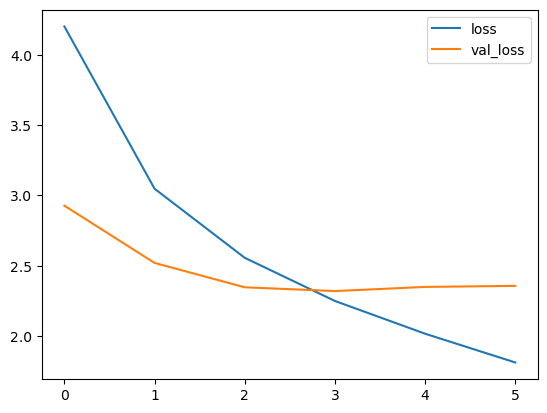

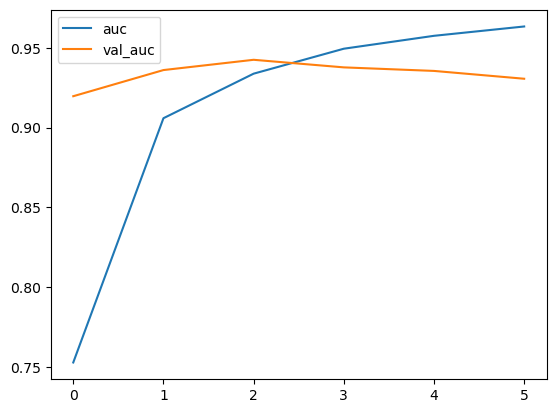

In [44]:
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['auc', 'val_auc']].plot() 
plt.show()

In [47]:
model.save("dog_breed_classifier.keras")

In [48]:
model.save("dog_breed_classifier.h5")

In [49]:
import pickle

# After you fit it!
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)